In [1]:
# data manipulation and cleaning
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import datetime
from functools import reduce



# visualisation
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import seaborn as sns

plt.style.use('ggplot')

# 0. Framework 

This is the framework we will use to prepare the report. The Goals of the notebook are as follow: 

- load the data
- EDA, clean up the data to map the "Exclusions" constraints
- transform the data to prepare the reports "PPR - Export" and "Market Trends"
- Analyse the data and prepare visualisations

Some personal assumptions: 
- I will assume that point 2 and 3 are equivalent and thus, cleaning up after applying the constraints is accepted (despite the implicit information loss); 

We have few constraints to apply to the data:     
- we want to consider only the period between Jan 2014 and Dec 2019
- we want to exclude new homes transactions
- we want to exclude not market value transactions 
- Counties not included in the Ulster province
- Bulk transactions (multiple units sold as part of the same transaction) 
- Transactions below € 10.000
- VAT excluded transactions
- Duplicate transactions


## Summary

The initial exploration [Section 1 and 2] aims at evaluating the information loss and understanding the data set.  The definition of "clean data set" is based on the "Market insights Province: Ulsters - Existing homes" requirements and higlighted above. 

We also evaluated the documentation provided in the Registry website (https://www.propertypriceregister.ie/)

Section 3 is used to aggregate the polished data set and prepare the insight report "Market trends". 

Section 4 produce the scripts that partially automatise the process. 

Recommendations and next steps: 
- Additional Exploratory analysis could be done to refine the logic by which bulk transactions are identified. Currently, we apply an hard coded logic (same address, same price, same date). This logic, however, might miss some transactions where the information is more dispersed (e.g. when only one instances of the transaction for only one apartment is logged with a price that is that of all the apartments bought). One way to improve the filtering, could be to evaluate the size of transaction per apartment and evaluate wether the transaction is an outlier (~2.5std) from the average transaction for the area/apartment type. However, this evaluation is difficult given the incomplete information on the apartment size/description
- One potential improvement of the data set would be to enrich the information with additional signals. For example, wether the buyer was an individual, a corporation or a non-profit. This enrichment would allow to acquire more information, while maintaining the privacy of the buyers. 
- Another data-driven improvement could be to enrich the data with additional information on the status/size/description. The data set is currently missing this information that could be used to better estimate and evaluate the potential profits
- Another data point that could be interesting to explore is the migration statistics related to the regions in examine. For example, if we are able to map the market fluctuation with the type of population moving in the market, we could be able to exploit this information to understand the risk presented by the investment. For example, a population that doesn't present a higher index in terms of children and has high-paying jobs, represent a lucrative opportunity with the caveat that the investment would probably need more maintaineance and refurbishing and thus, increase the operational cost to be taken into account when assessing the risk of the investment. 
- Currently, the function implements hard coded logic to the report creation. Although this map to the wanted output, a better approach could be to prepare the function to handle different raw data and apply the logic dynamically. 
- Two main factors that help evaluate real estate investments are Price-to-income Ratio (PIR, defined as median household price over median household income) and Price-To-Rent Ratio (PRR defined as median household price over median yearly rent). These two factors can help evaluate the performance of an investment based on the buying power of the region (PIR) and the expected output of the region, based on the location of the real estate. For example, the PIR in the US prior to the market melt-down was ~2.5 (https://www.investopedia.com/financial-edge/0511/8-must-have-numbers-for-evaluating-a-real-estate-investment.aspx)


# 1. Load the data 

In [2]:
# import csv
raw = pd.read_csv('Q1_2020_Data_analyst_transactions.csv')

# create a copy for manipulation
df = raw.copy()

# 2. EDA and data cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410523 entries, 0 to 410522
Data columns (total 10 columns):
id                           410523 non-null int64
Date of Sale (dd/mm/yyyy)    410523 non-null object
Address                      410523 non-null object
Postal Code                  76876 non-null object
County                       410523 non-null object
Price                        410523 non-null object
Not Full Market Price        410523 non-null object
VAT Exclusive                410523 non-null object
Description of Property      410523 non-null object
Property Size Description    52567 non-null object
dtypes: int64(1), object(9)
memory usage: 31.3+ MB


We explore the data, we notice that Postal Code have a lot of missing values. This shouldn't surprise, as the PostCode in Ireland are pretty recent. Another variable with high degree of missing values is Property Size Description.

We realise that the format of the raw data is already similar to the final format required for the PPR - Export. This should be our first task:

- Adapt the column names
- Transform object-type to consistent data type 

In [4]:
df.Price.describe()

count         410523
unique         26177
top       150,000.00
freq            5474
Name: Price, dtype: object

## 2.1 Adapt column names

In [5]:
# the only column to be renamed is the Date column 
df.rename(columns = {'Date of Sale (dd/mm/yyyy)':'Date'}, inplace = True)

# we also want to transform the object-type date column into a date format for easier handling later on
df['Date'] = pd.to_datetime(df['Date'])

# # convert other columns to category as they are easier data types
df['Price'] = df['Price'].str.replace(',', '').astype(float)





In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410523 entries, 0 to 410522
Data columns (total 10 columns):
id                           410523 non-null int64
Date                         410523 non-null datetime64[ns]
Address                      410523 non-null object
Postal Code                  76876 non-null object
County                       410523 non-null object
Price                        410523 non-null float64
Not Full Market Price        410523 non-null object
VAT Exclusive                410523 non-null object
Description of Property      410523 non-null object
Property Size Description    52567 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(7)
memory usage: 31.3+ MB


## 2.2 Add the province 

We want now to generate an additional label for the Province. A google search allow us to identify the counties that are associated with each province. The definitons are: 

Irish Provinces:
- Leinster (https://it.wikipedia.org/wiki/Leinster) => Carlow, Dublin, Kildare, Kilkenny, Laois, Longford, Louth, Meath, Offaly, Westmeath, Wexford e Wicklow.
- Ulster (https://it.wikipedia.org/wiki/Ulster) => Antrim, Armagh, Down, Fermanagh, Londonderry Tyrone, Cavan, Donegal, Monaghan
- Munster (https://it.wikipedia.org/wiki/Munster) => Cork, Clare, Kerry, Limerick, Tipperary, Waterford
- Connaught (https://it.wikipedia.org/wiki/Connaught) =>  Galway, Leitrim, Mayo, Roscommon, Sligo



In [7]:
# here we set the labels for the province. 
# there is a lot of repetition, so probably we want to optimise this
df['Province'] = df['County']

# here we are interested in identifying the Ulster Province. Therefore we will label only the Counties that match our description

ulster = ['Antrim', 'Armagh', 'Down', 'Fermanagh', 'Londonderry', 'Tyrone', 'Cavan', 'Donegal', 'Monaghan']
leinster =  ['Carlow', 'Dublin', 'Kildare', 'Kilkenny', 'Laois', 'Longford', 'Louth', 'Meath', 'Offaly', 'Westmeath', 'Wexford', 'Wicklow']
munster = ['Cork', 'Clare', 'Kerry', 'Limerick', 'Tipperary', 'Waterford']
connaught = ['Galway', 'Leitrim', 'Mayo', 'Roscommon', 'Sligo'] 

df.loc[df['Province'].isin(ulster), 'Province'] = 'Ulster'
df.loc[df['Province'].isin(leinster), 'Province'] = 'Leinster'
df.loc[df['Province'].isin(munster), 'Province'] = 'Munster'
df.loc[df['Province'].isin(connaught), 'Province'] = 'Connaught'



In [8]:
df.head(20)

,id,Date,Address,Postal Code,County,Price,Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description,Province
0,1,2010-01-01,"5 Braemor Drive, Churchtown, Co.Dublin",NaN,Dublin,343000.0,No,No,Second-Hand Dwelling house /Apartment,NaN,Leinster
1,2,2010-03-01,"134 Ashewood Walk, Summerhill Lane, Portlaoise",NaN,Laois,185000.0,No,Yes,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...,Leinster
2,11,2010-04-01,"16 Aisling Geal, Fr. Russell Road",NaN,Limerick,110000.0,No,No,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...,Munster
3,21,2010-04-01,"48 KILLIANS COURT, MULLAGH",NaN,Cavan,122000.0,No,Yes,New Dwelling house /Apartment,greater than 125 sq metres,Ulster
4,35,2010-04-01,"Knock, Lanesboro",NaN,Longford,125000.0,No,No,Second-Hand Dwelling house /Apartment,NaN,Leinster
5,10,2010-04-01,"15a Moore Bay, Kilkee",NaN,Clare,126500.0,No,No,Second-Hand Dwelling house /Apartment,NaN,Munster
6,25,2010-04-01,"59 ormond keep, nenagh",NaN,Tipperary,128000.0,No,No,Second-Hand Dwelling house /Apartment,NaN,Munster
7,26,2010-04-01,"66 Rory O'Connor Place, Arklow",NaN,Wicklow,145000.0,No,No,Second-Hand Dwelling house /Apartment,NaN,Leinster
8,32,2010-04-01,"Cloonlaughnan, Mount Talbot",NaN,Roscommon,145000.0,No,Yes,New Dwelling house /Apartment,greater than 125 sq metres,Connaught
9,28,2010-04-01,"90 Suncroft Drive, Tallaght, Dublin 24",NaN,Dublin,147950.0,No,No,Second-Hand Dwelling house /Apartment,NaN,Leinster


## 2.3 Add the month end day

In [9]:
# adding month end day based on date
df['Month_end_day'] = pd.to_datetime(df['Date'], format="%Y%m") + MonthEnd(0)

df.head()

,id,Date,Address,Postal Code,County,Price,Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description,Province,Month_end_day
0,1,2010-01-01,"5 Braemor Drive, Churchtown, Co.Dublin",NaN,Dublin,343000.0,No,No,Second-Hand Dwelling house /Apartment,NaN,Leinster,2010-01-31
1,2,2010-03-01,"134 Ashewood Walk, Summerhill Lane, Portlaoise",NaN,Laois,185000.0,No,Yes,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...,Leinster,2010-03-31
2,11,2010-04-01,"16 Aisling Geal, Fr. Russell Road",NaN,Limerick,110000.0,No,No,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...,Munster,2010-04-30
3,21,2010-04-01,"48 KILLIANS COURT, MULLAGH",NaN,Cavan,122000.0,No,Yes,New Dwelling house /Apartment,greater than 125 sq metres,Ulster,2010-04-30
4,35,2010-04-01,"Knock, Lanesboro",NaN,Longford,125000.0,No,No,Second-Hand Dwelling house /Apartment,NaN,Leinster,2010-04-30


## 2.4 Explore duplicates 

My assumption is that, to evaluate duplicates, we can rely on a combination of price and address present multiple times in multiple rows. We can verify if that's the case by looking at the number of unique rows by address and combine it with prices.

In [10]:
# first, we transform all the address in lower case
df['Address'] = df['Address'].str.lower()

# then we count the total number of unique address Total number of rows is 410523
print(df['Address'].nunique())

(df.groupby('Address')['Price'].count()).sort_values()


383312


Address
!5 ard coillte, ballina                     1
74 pebble drive, pebble beach, tramore      1
74 pearse park, tullamore, co offaly        1
74 pearse gardens, sallynoggin              1
74 patrician villas, stillorgan, dublin     1
                                           ..
lowville, ahascragh, ballinasloe           10
ballymakellett, ravensdale, dundalk        12
friarstown, grange, kilmallock             12
hillquarter, coosan, athlone               15
broomfield, midleton                       22
Name: Price, Length: 383312, dtype: int64

This would suggest that there is duplication that can be mapped to the address feature

In [11]:
# here we copy the initial data set and create one without dupes. We will use this later
df_no_dup =  df.copy()

df_no_dup.drop_duplicates(subset ="Address", 
                     keep = 'first', inplace = True)

df_no_dup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 383312 entries, 0 to 410522
Data columns (total 12 columns):
id                           383312 non-null int64
Date                         383312 non-null datetime64[ns]
Address                      383312 non-null object
Postal Code                  73335 non-null object
County                       383312 non-null object
Price                        383312 non-null float64
Not Full Market Price        383312 non-null object
VAT Exclusive                383312 non-null object
Description of Property      383312 non-null object
Property Size Description    51727 non-null object
Province                     383312 non-null object
Month_end_day                383312 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1), object(8)
memory usage: 38.0+ MB


## 2.5 Explore house description

In [12]:

df['Description of Property'].unique()

array(['Second-Hand Dwelling house /Apartment',
       'New Dwelling house /Apartment', 'Teach/¡ras·n CÛnaithe Ath·imhe',
       'Teach/¡ras·n CÛnaithe Nua', 'Teach/?ras?n C?naithe Nua'],
      dtype=object)

Other than Second hand and New house there are other categories that are not recognizable

In [13]:
df.groupby('Description of Property')['id'].count()

Description of Property
New Dwelling house /Apartment             65592
Second-Hand Dwelling house /Apartment    344899
Teach/?ras?n C?naithe Nua                     1
Teach/¡ras·n CÛnaithe Ath·imhe               29
Teach/¡ras·n CÛnaithe Nua                     2
Name: id, dtype: int64

These, however, seem to represent only a small fraction of the total. By considering only second-hand houses we retain 83% of the information

In [14]:
df.loc[df['Description of Property'].str.contains("Teach") ]

,id,Date,Address,Postal Code,County,Price,Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description,Province,Month_end_day
1160,1145,2010-01-02,"247 glanntan, golf links road, castletroy.",NÌ Bhaineann,Limerick,228500.00,No,No,Teach/¡ras·n CÛnaithe Ath·imhe,NaN,Munster,2010-01-31
12764,12751,2010-08-20,"8 millhill park, skerries.",NaN,Dublin,320000.00,No,No,Teach/¡ras·n CÛnaithe Ath·imhe,NaN,Leinster,2010-08-31
17324,17312,2010-02-11,"carrigvore, killiskey.",NaN,Wicklow,610000.00,No,No,Teach/¡ras·n CÛnaithe Ath·imhe,NaN,Leinster,2010-02-28
20034,20121,2010-12-16,"7 cul na toinne, bunbeg.",NaN,Donegal,74889.87,No,Yes,Teach/¡ras·n CÛnaithe Nua,nÌos mÛ n· nÛ cothrom le 38 mÈadar cearnach ag...,Ulster,2010-12-31
22624,22655,2011-02-16,"racecourse road, roscommon.",NÌ Bhaineann,Roscommon,100000.00,No,No,Teach/¡ras·n CÛnaithe Ath·imhe,NaN,Connaught,2011-02-28
26873,26791,2011-05-27,"12 southdene, gleann bhaile na manach, baile n...",Baile ¡tha Cliath 14,Dublin,272000.00,No,No,Teach/¡ras·n CÛnaithe Ath·imhe,NaN,Leinster,2011-05-31
32172,32198,2011-07-09,"station road, castlebellingham, dundalk.",NaN,Louth,179000.00,No,No,Teach/¡ras·n CÛnaithe Ath·imhe,NaN,Leinster,2011-07-31
39758,39774,2012-12-01,"apartment 12 block b, corofin house clare vi...",Baile ?tha Cliath 17,Dublin,115045.00,No,Yes,Teach/?ras?n C?naithe Nua,n?os l? n? 38 m?adar cearnach,Leinster,2012-12-31
48868,48861,2012-06-28,"7 thorndale grove, artane, dublin.",Baile ¡tha Cliath 5,Dublin,250000.00,No,No,Teach/¡ras·n CÛnaithe Ath·imhe,NaN,Leinster,2012-06-30
54057,53982,2012-10-09,"121 ardilaun, portmarnock, co dublin.",NÌ Bhaineann,Dublin,375000.00,No,No,Teach/¡ras·n CÛnaithe Ath·imhe,NaN,Leinster,2012-10-31


By exploring this sub-class, we notice that for the purpose of our report (Ulster, 2014-2019) we won't lose a lot of information by dropping these sub-class. That's why we decide to drop

## 2.6 No Market value

For the purpose of our report, we want to exclude transactions that are not "At Market value". In the raw data set these transactions where marked as ** (https://propertypriceregister.ie/Website/NPSRA/pprweb.nsf/page/ppr-home-en)

In [15]:
df[df['Not Full Market Price'] == 'Yes'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19876 entries, 11 to 410431
Data columns (total 12 columns):
id                           19876 non-null int64
Date                         19876 non-null datetime64[ns]
Address                      19876 non-null object
Postal Code                  3972 non-null object
County                       19876 non-null object
Price                        19876 non-null float64
Not Full Market Price        19876 non-null object
VAT Exclusive                19876 non-null object
Description of Property      19876 non-null object
Property Size Description    1441 non-null object
Province                     19876 non-null object
Month_end_day                19876 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1), object(8)
memory usage: 2.0+ MB


We have ~5% of cases that fall under this category. 

In [16]:
df[df['Not Full Market Price'] == 'Yes'].groupby('Province').count()

,id,Date,Address,Postal Code,County,Price,Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description,Month_end_day
Province,,,,,,,,,,,
Connaught,1893,1893,1893,0,1893,1893,1893,1893,1893,100,1893
Leinster,11889,11889,11889,3972,11889,11889,11889,11889,11889,820,11889
Munster,4962,4962,4962,0,4962,4962,4962,4962,4962,433,4962
Ulster,1132,1132,1132,0,1132,1132,1132,1132,1132,88,1132


Only a small fraction belong to the Province we are interested in

## 2.7 Price < 10k

In [17]:
# we are interested in transactions that are higher than 10k
df[df['Price'] < 10000].groupby('Province').count()

,id,Date,Address,Postal Code,County,Price,Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description,Month_end_day
Province,,,,,,,,,,,
Connaught,116,116,116,0,116,116,116,116,116,39,116
Leinster,356,356,356,214,356,356,356,356,356,187,356
Munster,213,213,213,0,213,213,213,213,213,38,213
Ulster,52,52,52,0,52,52,52,52,52,2,52


Only few transactions are below our threshold in Ulster. 

## 2.8 Vat Excluded

We are only interested in transactions that are not Vat Excluded

In [18]:
df[df['VAT Exclusive'] == 'Yes'].groupby('Province').count()

,id,Date,Address,Postal Code,County,Price,Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description,Month_end_day
Province,,,,,,,,,,,
Connaught,5327,5327,5327,0,5327,5327,5327,5327,5327,4656,5327
Leinster,43445,43445,43445,9585,43445,43445,43445,43445,43445,33949,43445
Munster,12709,12709,12709,1,12709,12709,12709,12709,12709,10228,12709
Ulster,2710,2710,2710,0,2710,2710,2710,2710,2710,2471,2710


Also in this case, we realise that the fraction of this sub-class doesn't present a huge loss of information for the category we are interested in

## 2.9 Bulk transactions

Here we are interested in understanding wether the transaction bought multiple assets. Since this will require a bit of investigation, I decide to narrow down the data set and apply the previous filters already.

In [19]:
# here we want to select the timeframe between Jan 2014 and December 2019. We include the months.
time_mask = (df_no_dup['Date'] >= '2014-01-01') & (df_no_dup['Date'] <= '2019-12-31')
province_mask = (df_no_dup['Province'] == 'Ulster')
new_mask = (df_no_dup['Description of Property'].str.contains("Second-Hand "))
no_market_value = (df['Not Full Market Price'] == 'No')
low_transaction = (df['Price'] > 10000)
vat_excluded = (df['VAT Exclusive'] == 'No')

polished_df = df_no_dup[time_mask & province_mask & new_mask & no_market_value & low_transaction & vat_excluded]

/Users/mmiraula/pyenv3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [20]:
polished_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12093 entries, 94794 to 410522
Data columns (total 12 columns):
id                           12093 non-null int64
Date                         12093 non-null datetime64[ns]
Address                      12093 non-null object
Postal Code                  1 non-null object
County                       12093 non-null object
Price                        12093 non-null float64
Not Full Market Price        12093 non-null object
VAT Exclusive                12093 non-null object
Description of Property      12093 non-null object
Property Size Description    0 non-null object
Province                     12093 non-null object
Month_end_day                12093 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1), object(8)
memory usage: 1.2+ MB


In order to identify transactions that occurred in bulk, we will take into account address, price and date of transaction. We want to initially split the address into independent pieces

In [21]:
polished_df = pd.concat([polished_df, polished_df['Address'].str.split(', ', expand=True)], axis=1)

polished_df

,id,Date,Address,Postal Code,County,Price,Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description,Province,Month_end_day,0,1,2
94794,94801,2014-02-01,"apt 1 begleys building, the diamond, donegal town",NaN,Donegal,80000.0,No,No,Second-Hand Dwelling house /Apartment,NaN,Ulster,2014-02-28,apt 1 begleys building,the diamond,donegal town
94795,94802,2014-02-01,"apt 2 begleys buildings, the diamond, donegal ...",NaN,Donegal,80000.0,No,No,Second-Hand Dwelling house /Apartment,NaN,Ulster,2014-02-28,apt 2 begleys buildings,the diamond,donegal town
94796,94804,2014-02-01,"apt 3 begleys building, the diamond, donegal town",NaN,Donegal,80000.0,No,No,Second-Hand Dwelling house /Apartment,NaN,Ulster,2014-02-28,apt 3 begleys building,the diamond,donegal town
94797,94805,2014-02-01,"apt 4 begleys building, the diamond, donegal town",NaN,Donegal,80000.0,No,No,Second-Hand Dwelling house /Apartment,NaN,Ulster,2014-02-28,apt 4 begleys building,the diamond,donegal town
94803,94814,2014-02-01,"tullan strand rd, bundoran, strand rd",NaN,Donegal,130000.0,No,No,Second-Hand Dwelling house /Apartment,NaN,Ulster,2014-02-28,tullan strand rd,bundoran,strand rd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410518,899475,2019-11-22,"88 o'neill park, clones, co monaghan",NaN,Monaghan,35000.0,No,No,Second-Hand Dwelling house /Apartment,NaN,Ulster,2019-11-30,88 o'neill park,clones,co monaghan
410519,899831,2019-11-26,"26 mullach glas crescent, monaghan, co. monagh...",NaN,Monaghan,145000.0,No,No,Second-Hand Dwelling house /Apartment,NaN,Ulster,2019-11-30,26 mullach glas crescent,monaghan,co. monaghan
410520,900375,2019-11-28,"6 maple grove, smithborough, monaghan",NaN,Monaghan,123000.0,No,No,Second-Hand Dwelling house /Apartment,NaN,Ulster,2019-11-30,6 maple grove,smithborough,monaghan
410521,900345,2019-11-28,"4 bramley grove, castleblaney, monaghan",NaN,Monaghan,143000.0,No,No,Second-Hand Dwelling house /Apartment,NaN,Ulster,2019-11-30,4 bramley grove,castleblaney,monaghan


We can already notice that there are some cases where the address, date and price is identical. However, the apartment number is different. These are good candidates to be identified as bulk transactions. We can remove those cases by selecting the rows where the 1st and 2nd split of the address and date and price are identical. In this case, we want to remove all these transactions, without keeping them.

In [22]:
# here, we take into account the cases where houses present the same address, date
(polished_df.sort_values(by=[0, 1, 2])[[1,2, 'Price', 'Date']].eq(polished_df[[1,2, 'Price', 'Date']].shift()))



,1,2,Price,Date
94794,False,False,False,False
94795,True,True,True,True
94796,True,True,True,True
94797,True,True,True,True
94803,False,False,False,True
...,...,...,...,...
410518,False,False,False,False
410519,False,False,False,False
410520,False,False,False,False
410521,False,True,False,True


By exploring the data set, when the bulk label is applied, we can see that the label seems to catch assets with characteristics of being bought in bulk correctly. However, for a more precise labelling, we could explore a cluster model. This is out of the scope of this project. 

In [23]:
polished_df.head()

,id,Date,Address,Postal Code,County,Price,Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description,Province,Month_end_day,0,1,2
94794,94801,2014-02-01,"apt 1 begleys building, the diamond, donegal town",NaN,Donegal,80000.0,No,No,Second-Hand Dwelling house /Apartment,NaN,Ulster,2014-02-28,apt 1 begleys building,the diamond,donegal town
94795,94802,2014-02-01,"apt 2 begleys buildings, the diamond, donegal ...",NaN,Donegal,80000.0,No,No,Second-Hand Dwelling house /Apartment,NaN,Ulster,2014-02-28,apt 2 begleys buildings,the diamond,donegal town
94796,94804,2014-02-01,"apt 3 begleys building, the diamond, donegal town",NaN,Donegal,80000.0,No,No,Second-Hand Dwelling house /Apartment,NaN,Ulster,2014-02-28,apt 3 begleys building,the diamond,donegal town
94797,94805,2014-02-01,"apt 4 begleys building, the diamond, donegal town",NaN,Donegal,80000.0,No,No,Second-Hand Dwelling house /Apartment,NaN,Ulster,2014-02-28,apt 4 begleys building,the diamond,donegal town
94803,94814,2014-02-01,"tullan strand rd, bundoran, strand rd",NaN,Donegal,130000.0,No,No,Second-Hand Dwelling house /Apartment,NaN,Ulster,2014-02-28,tullan strand rd,bundoran,strand rd


In [24]:
# # removing duplicate
polished_df.drop_duplicates(subset =[1,2, 'Price', 'Date'], # we want to remove all the bulk transactions
                     keep = False, inplace = True)


In [25]:
polished_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11239 entries, 94803 to 410522
Data columns (total 15 columns):
id                           11239 non-null int64
Date                         11239 non-null datetime64[ns]
Address                      11239 non-null object
Postal Code                  1 non-null object
County                       11239 non-null object
Price                        11239 non-null float64
Not Full Market Price        11239 non-null object
VAT Exclusive                11239 non-null object
Description of Property      11239 non-null object
Property Size Description    0 non-null object
Province                     11239 non-null object
Month_end_day                11239 non-null datetime64[ns]
0                            11239 non-null object
1                            11239 non-null object
2                            10677 non-null object
dtypes: datetime64[ns](2), float64(1), int64(1), object(11)
memory usage: 1.4+ MB


## 3 Creating Reports


In [26]:
def ppr_report(csv):
    """
    This function generates the PPR - Export report
    It loads a csv and applies the transformation needed to the raw data.
    The input is the string type of the csv name
    IMPORTANT: The output of the report already includes the exclusion parameters
    """
    
    ppr_export = pd.read_csv(str(csv)+str('.csv'))
    # the only column to be renamed is the Date column 
    ppr_export.rename(columns = {'Date of Sale (dd/mm/yyyy)':'Date'}, inplace = True)

    # we also want to transform the object-type date column into a date format for easier handling later on
    ppr_export['Date'] = pd.to_datetime(ppr_export['Date'])

    #add the last day of the month
    ppr_export['Month_end_day'] = pd.to_datetime(ppr_export['Date'], format="%Y%m") + MonthEnd(0)
    
    # # convert other columns to category as they are easier data types
    ppr_export['Price'] = ppr_export['Price'].str.replace(',', '').astype(float)

    # here we remove the duplicates and bulk transactions
    ppr_export['Address'] = ppr_export['Address'].str.lower()
    ppr_export.drop_duplicates(subset ="Address", 
                     keep = 'first', inplace = True)
    ppr_export = pd.concat([ppr_export, ppr_export['Address'].str.split(', ', expand=True)], axis=1)
    ppr_export.drop_duplicates(subset =[1,2, 'Price', 'Date'], 
                     keep = False, inplace = True)
    
    # here we want to select the timeframe between Jan 2014 and December 2019. We include the months.
    time_mask = (ppr_export['Date'] >= '2014-01-01') & (ppr_export['Date'] <= '2019-12-31')
    # here we are interested in identifying the Ulster Province. Therefore we will label the Counties that match our description
    ulster = ['Antrim', 'Armagh', 'Down', 'Fermanagh', 'Londonderry', 'Tyrone', 'Cavan', 'Donegal', 'Monaghan']
    leinster =  ['Carlow', 'Dublin', 'Kildare', 'Kilkenny', 'Laois', 'Longford', 'Louth', 'Meath', 'Offaly', 'Westmeath', 'Wexford' 'Wicklow']
    munster = ['Cork', 'Clare', 'Kerry', 'Limerick', 'Tipperary', 'Waterford']
    connaught = ['Galway', 'Leitrim', 'Mayo', 'Roscommon', 'Sligo'] 
    ppr_export['Province'] = ppr_export['County']
    
    ppr_export.loc[ppr_export['Province'].isin(ulster), 'Province'] = 'Ulster'
    ppr_export.loc[ppr_export['Province'].isin(leinster), 'Province'] = 'Leinster'
    ppr_export.loc[ppr_export['Province'].isin(munster), 'Province'] = 'Munster'
    ppr_export.loc[ppr_export['Province'].isin(connaught), 'Province'] = 'Connaught'
    # here we generate a mask to select the province we are interested in
    province_mask = (ppr_export.loc[ppr_export['County'].isin(ulster), 'County'])
    # here we create the label for second-hand houses
    new_mask = (ppr_export['Description of Property'].str.contains("Second-Hand "))
    # here we exclude houses that are not at market value
    no_market_value = (ppr_export['Not Full Market Price'] == 'No')
    # here we exclude the cases where the transaction amount is less than 10k
    low_transaction = (ppr_export['Price'] > 10000)
    # here we exclude the cases where there is a Vat exemption
    vat_excluded = (ppr_export['VAT Exclusive'] == 'No')

    
    # we apply the masks and drop column that don't need
    ppr_export = ppr_export[time_mask & province_mask & new_mask & no_market_value & low_transaction & vat_excluded]
    ppr_export.drop([0, 1, 2], axis=1, inplace = True)
    
    return ppr_export


ppr_export = ppr_report('Q1_2020_Data_analyst_transactions')

In [27]:
ppr_export.head()

,id,Date,Address,Postal Code,County,Price,Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description,Month_end_day,Province
94803,94814,2014-02-01,"tullan strand rd, bundoran, strand rd",NaN,Donegal,130000.0,No,No,Second-Hand Dwelling house /Apartment,NaN,2014-02-28,Ulster
94825,94846,2014-03-01,"liseux, rahardum, virginia",NaN,Cavan,70000.0,No,No,Second-Hand Dwelling house /Apartment,NaN,2014-03-31,Ulster
94910,94935,2014-07-01,"58 stradabrooey, gweedore, donegal",NaN,Donegal,33000.0,No,No,Second-Hand Dwelling house /Apartment,NaN,2014-07-31,Ulster
94941,94940,2014-07-01,"7 woodbrook, kinnegar rd, rathmullan",NaN,Donegal,150000.0,No,No,Second-Hand Dwelling house /Apartment,NaN,2014-07-31,Ulster
94949,94944,2014-07-01,"ankari, lackenmore, new inns",NaN,Cavan,169000.0,No,No,Second-Hand Dwelling house /Apartment,NaN,2014-07-31,Ulster


In [28]:
# counties we are interested in 
counties = ['Antrim', 'Armagh', 'Down', 'Fermanagh', 'Londonderry', 'Tyrone', 'Cavan', 'Donegal', 'Monaghan']

def market_report(raw_df,county):
    """
    This function accept the dataframe generated and create the market report with aggregated values
    """
    #add the last day of the month
    
    # total transactions on a rolling basis
    monthly_tr = round(raw_df[raw_df['County']==county].groupby('Month_end_day')['id'].count(), 2).to_frame().reset_index(level=[0])
    semester_tr = round(raw_df[raw_df['County']==county].sort_values(by='Month_end_day').groupby('Month_end_day')['id'].count().rolling(6).sum(), 2).to_frame().reset_index(level=[0])
    yearly_tr = round(raw_df[raw_df['County']==county].sort_values(by='Month_end_day').groupby('Month_end_day')['id'].count().rolling(12).sum(), 2).to_frame().reset_index(level=[0])

    # total sales volume on a rolling basis
    monthly_sales = round(raw_df[raw_df['County']==county].groupby('Month_end_day')['Price'].sum(), 2).to_frame()
    semester_sales = round(raw_df[raw_df['County']==county].sort_values(by='Month_end_day').groupby('Month_end_day')['Price'].sum().rolling(6).sum(), 2).to_frame().reset_index(level=[0])
    yearly_sales = round(raw_df[raw_df['County']==county].sort_values(by='Month_end_day').groupby('Month_end_day')['Price'].sum().rolling(12).sum(), 2).to_frame().reset_index(level=[0])

    # median sales price. Something to note, the resampling starts at the beginning of 2014, thus the first month (Jan) is obtaining the median of only the first month
    p50_3mo_sales = raw_df[raw_df['County'] == county].set_index('Month_end_day').sort_values(by='Month_end_day')['Price'].resample('3M', convention = 'start').median()
    p50_6mo_sales = raw_df[raw_df['County'] == county].set_index('Month_end_day').sort_values(by='Month_end_day')['Price'].resample('6M', convention = 'start').median()
    p50_12mo_sales = raw_df[raw_df['County'] == county].set_index('Month_end_day').sort_values(by='Month_end_day')['Price'].resample('12M', convention = 'start').median()


    # median change (simple delta from the median)
    p50_3mo_sales_chng = p50_3mo_sales.pct_change()
    p50_12mo_sales_chng = p50_12mo_sales.pct_change()

    # percentiiles
    p25_12mo_sales = raw_df[raw_df['County'] == county].set_index('Month_end_day').sort_values(by='Month_end_day')['Price'].resample('12M').quantile(.25)
    p75_12mo_sales = raw_df[raw_df['County'] == county].set_index('Month_end_day').sort_values(by='Month_end_day')['Price'].resample('12M').quantile(.75)
    
    # df that we want to merge, already in the right order
    df_to_merge = [ yearly_tr, semester_tr,monthly_tr,
                   yearly_sales,semester_sales, monthly_sales, 
                   p50_12mo_sales,p50_6mo_sales,p50_3mo_sales, 
                   p50_12mo_sales_chng, p50_3mo_sales_chng,
                    p25_12mo_sales, p75_12mo_sales]

    # here we merge all the df in one go
    df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Month_end_day'],
                                            how= 'left'), df_to_merge)
    
    df_merged['County'] = i
    df_merged['Province'] = 'Ulster'
    

    return df_merged



# here we generate an empty container to add all the dataframes concatenated
market_report_df = []

# here we iterate over all the counties in Ulster and stack the different aggregation together
for i in counties:
    df = market_report(ppr_export, i)
    market_report_df.append(df)    
    
market_report_df = pd.concat(market_report_df)

# rename and re-order columns to match the expected output the columns
market_report_df.columns = ['Month_end_day', 
                            'year_tr','semester_tr','monthly_tr',
                            'yearly_sales', 'semester_sales','monthly_sales',
                            'p50_12mo_sales','p50_6mo_sales',  'p50_3mo_sales',
                            'p50_12mo_sales_chng',  'p50_3mo_sales_chng',
                            'p25_12mo_sales','p75_12mo_sales', 'County', 'Province']

market_report_df = market_report_df[['Province','County',  'Month_end_day', 
                            'year_tr','semester_tr','monthly_tr',
                            'yearly_sales', 'semester_sales','monthly_sales',
                            'p50_12mo_sales','p50_6mo_sales',  'p50_3mo_sales',
                            'p50_12mo_sales_chng',  'p50_3mo_sales_chng',
                            'p25_12mo_sales','p75_12mo_sales' ]]

market_report_df_formatted = market_report_df.copy()

# here we want to format the columns with sales amount with the $ or % sign and show in comprehensible units. 
# However, we will generate a separate dataframe that is specific for the report and not for the visualisation
columns_to_format_dollar = ['yearly_sales','semester_sales','monthly_sales','p50_12mo_sales','p50_6mo_sales','p50_3mo_sales', 'p25_12mo_sales','p75_12mo_sales']
columns_to_format_pct = ['p50_12mo_sales_chng', 'p50_3mo_sales_chng']

market_report_df_formatted[columns_to_format_dollar] = market_report_df_formatted[columns_to_format_dollar].astype(float).applymap('${:,.2f}'.format)
market_report_df_formatted[columns_to_format_pct] = market_report_df_formatted[columns_to_format_pct].astype(float).applymap('{:,.2%}'.format)
# # market_report_printable = market_report_df.copy().loc[:, columns_to_format_pct] = market_report_df[columns_to_format_pct].astype(float).applymap('{:,.2%}'.format)
market_report_df_formatted


,Province,County,Month_end_day,year_tr,semester_tr,monthly_tr,yearly_sales,semester_sales,monthly_sales,p50_12mo_sales,p50_6mo_sales,p50_3mo_sales,p50_12mo_sales_chng,p50_3mo_sales_chng,p25_12mo_sales,p75_12mo_sales
0,Ulster,Cavan,2014-01-31,NaN,NaN,30,$nan,$nan,"$2,169,250.00","$60,500.00","$60,500.00","$60,500.00",nan%,nan%,"$35,000.00","$91,750.00"
1,Ulster,Cavan,2014-02-28,NaN,NaN,31,$nan,$nan,"$2,627,000.00",$nan,$nan,$nan,nan%,nan%,$nan,$nan
2,Ulster,Cavan,2014-03-31,NaN,NaN,41,$nan,$nan,"$3,855,860.00",$nan,$nan,$nan,nan%,nan%,$nan,$nan
3,Ulster,Cavan,2014-04-30,NaN,NaN,34,$nan,$nan,"$3,023,583.00",$nan,$nan,"$70,000.00",nan%,15.70%,$nan,$nan
4,Ulster,Cavan,2014-05-31,NaN,NaN,37,$nan,$nan,"$3,744,500.00",$nan,$nan,$nan,nan%,nan%,$nan,$nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,Ulster,Monaghan,2019-08-31,284.0,138.0,16,"$43,738,279.50","$21,128,804.50","$2,001,000.00",$nan,$nan,$nan,nan%,nan%,$nan,$nan
68,Ulster,Monaghan,2019-09-30,283.0,127.0,18,"$43,120,279.50","$18,992,704.50","$2,879,500.00",$nan,$nan,$nan,nan%,nan%,$nan,$nan
69,Ulster,Monaghan,2019-10-31,279.0,128.0,25,"$43,019,279.50","$19,221,204.50","$3,771,500.00",$nan,$nan,"$140,000.00",nan%,1.82%,$nan,$nan
70,Ulster,Monaghan,2019-11-30,287.0,153.0,46,"$44,466,304.50","$22,485,188.50","$6,591,400.00",$nan,$nan,$nan,nan%,nan%,$nan,$nan


## 4 Visualisation

In [29]:
# Since we have large dollar amounts in the sales column, we can use a simple function to get the desired order of magnitude
def tick_value_formatter(tick_val, pos):
    """
    Turns large tick values (in the billions, millions and thousands) and also appropriately turns 4000 into 4K (no zero after the decimal).
    """
    if tick_val >= 1000000000:
        val = round(tick_val/1000000000, 1)
        new_tick_format = '{:}B'.format(val)
    elif tick_val >= 1000000:
        val = round(tick_val/1000000, 1)
        new_tick_format = '{:}M'.format(val)
    elif tick_val >= 1000:
        val = round(tick_val/1000, 1)
        new_tick_format = '{:}K'.format(val)
    elif tick_val < 1000:
        new_tick_format = round(tick_val, 1)
    else:
        new_tick_format = tick_val

    # make new_tick_format into a string value
    new_tick_format = str(new_tick_format)
    
    # code below will keep 4.5M as is but change values such as 4.0M to 4M since that zero after the decimal isn't needed
    index_of_decimal = new_tick_format.find(".")
    
    if index_of_decimal != -1:
        value_after_decimal = new_tick_format[index_of_decimal+1]
        if value_after_decimal == "0":
            # remove the 0 after the decimal point since it's not needed
            new_tick_format = new_tick_format[0:index_of_decimal] + new_tick_format[index_of_decimal+2:]
            
    return new_tick_format

### Description of the market trends

We extract the monthly trend by county. This would allow us to evaluate if there are clear seasonalities for number of transactions and sales volume during the year and across the years taken into account. 

/Users/mmiraula/pyenv3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


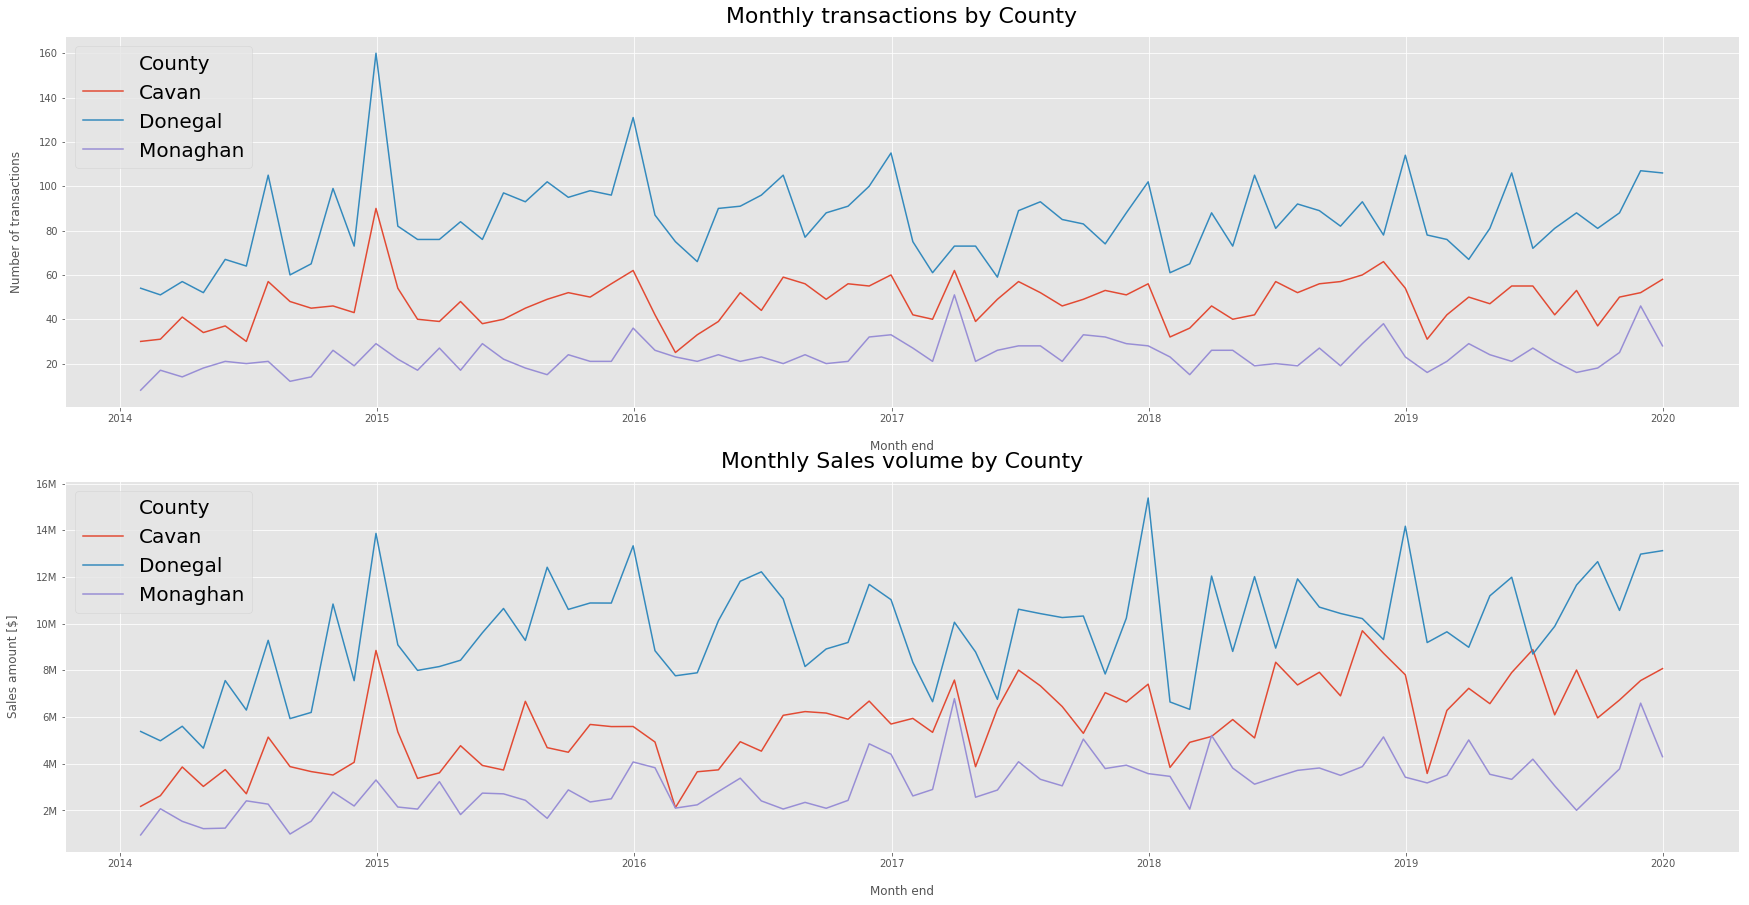

In [30]:

# here we prepare the plots. 
fig_dims = (30, 15)
fig, (ax1,ax2) = plt.subplots(2,figsize=fig_dims)


ax1 = sns.lineplot(x='Month_end_day', y="monthly_tr",
                  data=market_report_df, ax=ax1, hue = 'County')



ax1.set_xlabel("Month end", labelpad=16)
ax1.set_ylabel("Number of transactions", labelpad=16)
ax1.set_title("Monthly transactions by County", y=1.02, fontsize=22)
ax1.yaxis.set_major_formatter(tick.FuncFormatter(tick_value_formatter))
ax1.legend(loc=2, prop={'size': 20});


ax2 = sns.lineplot(x="Month_end_day", y="monthly_sales", hue="County",
                  data=market_report_df, ax=ax2)

ax2.set_xlabel("Month end", labelpad=16)
ax2.set_ylabel("Sales amount [$]", labelpad=16)
ax2.set_title("Monthly Sales volume by County", y=1.02, fontsize=22)
ax2.yaxis.set_major_formatter(tick.FuncFormatter(tick_value_formatter))
ax2.legend(loc=2, prop={'size': 20});


Transaction and volume monthly trends show that Donegal is the county with most apparent interest in the housing market. The number of transactions, as well as the price volumes, are higher in this county. This could suggest a very dynamic market to operate but, at the same time, a market in which prices are probably saturated. 

Thus, the other two counties are more suitable candidates to evaluate investments. 

### Yearly Sales  
+ Prettifying visual

We also evaluate the yearly sales volume. This can give us a bigger picture of the market trends and als the YoY evolution of the prices in the counties.

/Users/mmiraula/pyenv3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


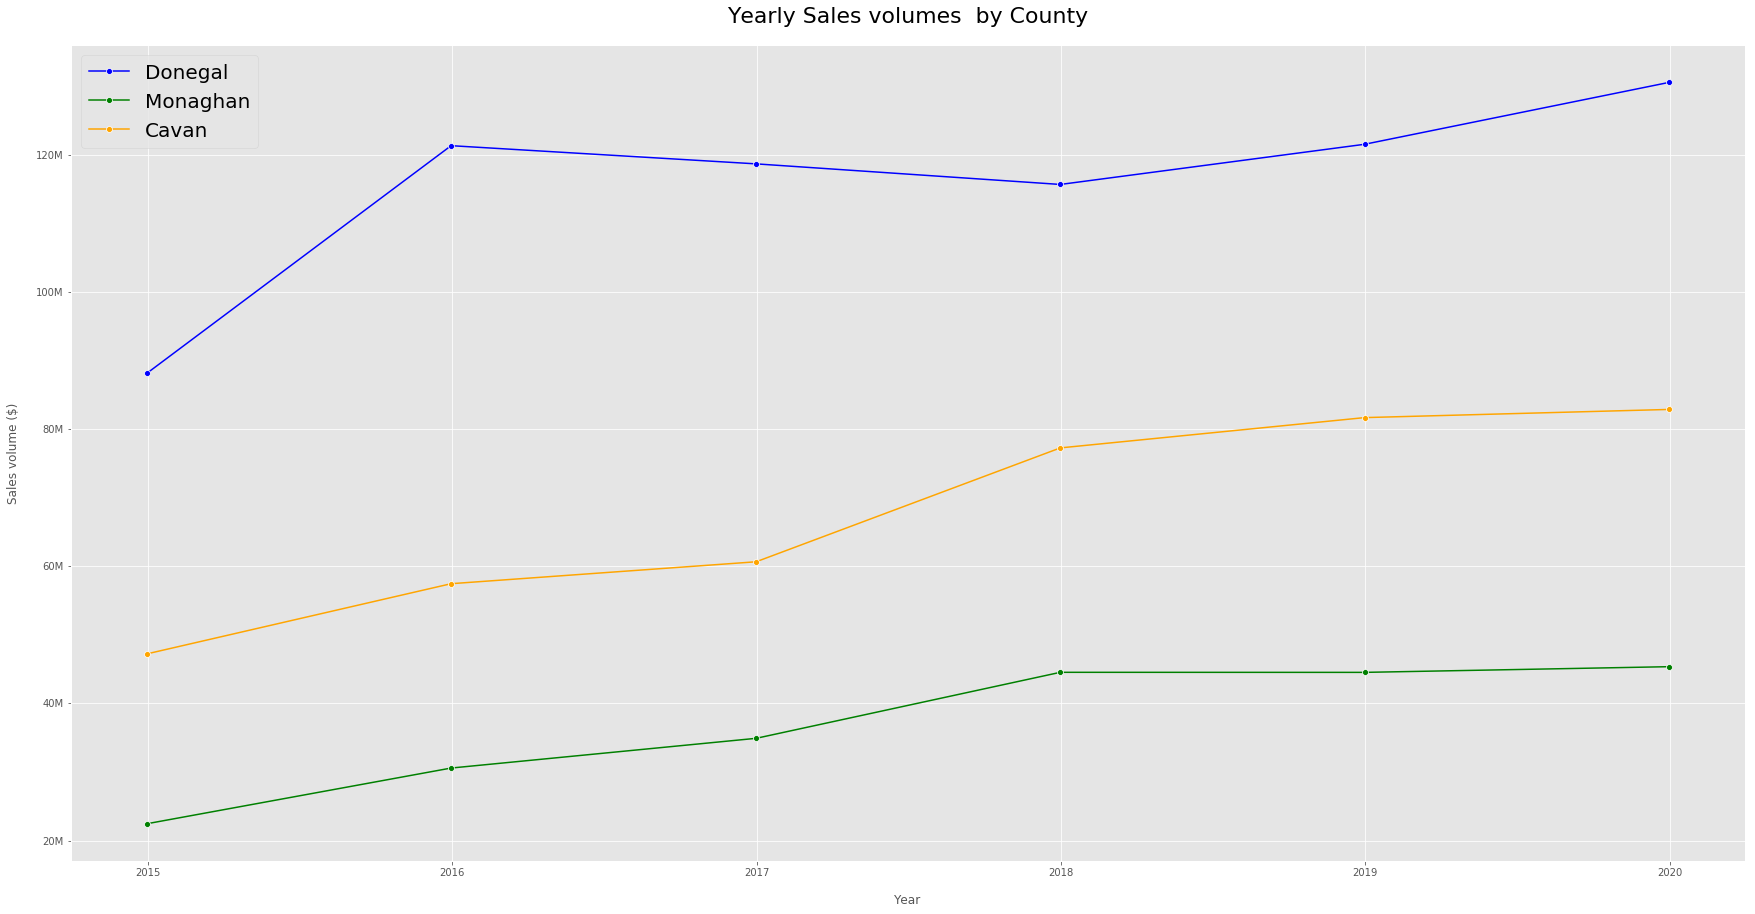

In [31]:

# here we prepare the figure 
fig_dims = (30, 15)
fig, (ax1) = plt.subplots(figsize=fig_dims)


# prepare mask to filter only county level and 12th month of every year
donegal = (market_report_df['County']=='Donegal')&(market_report_df['Month_end_day'].dt.month == 12)
monaghan = (market_report_df['County']=='Monaghan')&(market_report_df['Month_end_day'].dt.month == 12)
cavan = (market_report_df['County']=='Cavan')&(market_report_df['Month_end_day'].dt.month == 12)

ax1 = sns.lineplot(x='Month_end_day', 
                  y="yearly_sales", 
                  ax=ax1,
                  data = market_report_df[donegal],
                   markers=True, dashes=False,
                   marker="o",
                 c="blue", 
                  label = 'Donegal')


ax1 = sns.lineplot(x='Month_end_day', 
                  y="yearly_sales", 
                  ax=ax1,
                  data = market_report_df[monaghan],
                    marker="o",
                 c="green", 
                  label = 'Monaghan')


ax1 = sns.lineplot(x='Month_end_day', 
                  y="yearly_sales", 
                  ax=ax1,
                  data = market_report_df[cavan],
                   marker="o",
                 c="orange", 
                  label = 'Cavan')


ax1.set_xlabel("Year", labelpad=16)
ax1.set_ylabel("Sales volume ($)", labelpad=16)
ax1.set_title("Yearly Sales volumes  by County", y=1.02, fontsize=22)
ax1.yaxis.set_major_formatter(tick.FuncFormatter(tick_value_formatter))
ax1.legend(loc=2, prop={'size': 20})


County Donegal present higher sales values year over year. All three counties have observed growth over the course of the period observed. However, Monaghan and Cavan present a a less rapid increase in prices and a more steady growth YoY. From an investment perspective, it might make sense to target Monaghan and then Cavan, to exploit the market while the prices are still relatively lower than those in Donegal. 


## Indicators of market healthiness and opportunity for investment

+ Prettifying visual

Here, we look at two leading indicators that allow the estimation of the investment based on the median houselhold income and  median yearly rent of the regions we examine. 

Details rearding the indicators are found here: https://www.investopedia.com/financial-edge/0511/8-must-have-numbers-for-evaluating-a-real-estate-investment.aspx

Details around the statistics taken into account can be found here: 
- median household statistics 2016 https://www.cso.ie/en/releasesandpublications/ep/p-gpii/geographicalprofilesofincomeinireland2016/incomeinireland/
- median rent 2019 https://static.rasset.ie/documents/news/2019/05/2019-q1-rentalprice-daftreport.pdf

We don't have a clear historical data available for the two additional statistics needed. In particular, we have access to information related to 2016 for household income and 2019 for rent. Thus, we will need to make some assumptions to evaluate the impact of income and rent to the evaluation of the KPIs.

- The report [0] shows an increase in rent since 2014. In particular, there is a linear increase of ca. 30EUR of monthly rent increase per year (2014 to 2019, we see an increase from ~500EUR to 650EUR). We will apply this assumption to the region.  

- in terms of household income, we didn't find any reliable evidence to support a sound assumption. We will apply a rate of 2.5% increase per year (this assumption is based on the theoretical increase of the inflation rate, in the case of no economic downturn)

- These assumption should be further refined by evaluating the size/type of property and the data enriched with additional information regarding the population and its income. However, this data is not available at the time we are writing this report. 

[0] https://static.rasset.ie/documents/news/2019/05/2019-q1-rentalprice-daftreport.pdf

In [32]:
# generating list containing the income and rent adjusted
d_income_list = [30666.59, 31452.91, 32259.4, 33065.89, 33892.54, 34739.85]
m_income_list = [36998.61, 37947.29, 38920.3, 39893.31, 40890.64, 41912.91]
c_income_list = [36968.86, 37916.78, 38889, 39861.22, 40857.75, 41879.19]

d_rent_list = [495*12, 525*12, 555*12, 585*12, 615*12, 645*12]
m_rent_list = [649*12, 679*12, 709*12, 739*12, 769*12, 799*12]
c_rent_list = [590*12, 620*12, 650*12, 680*12, 710*12, 740*12]


/Users/mmiraula/pyenv3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


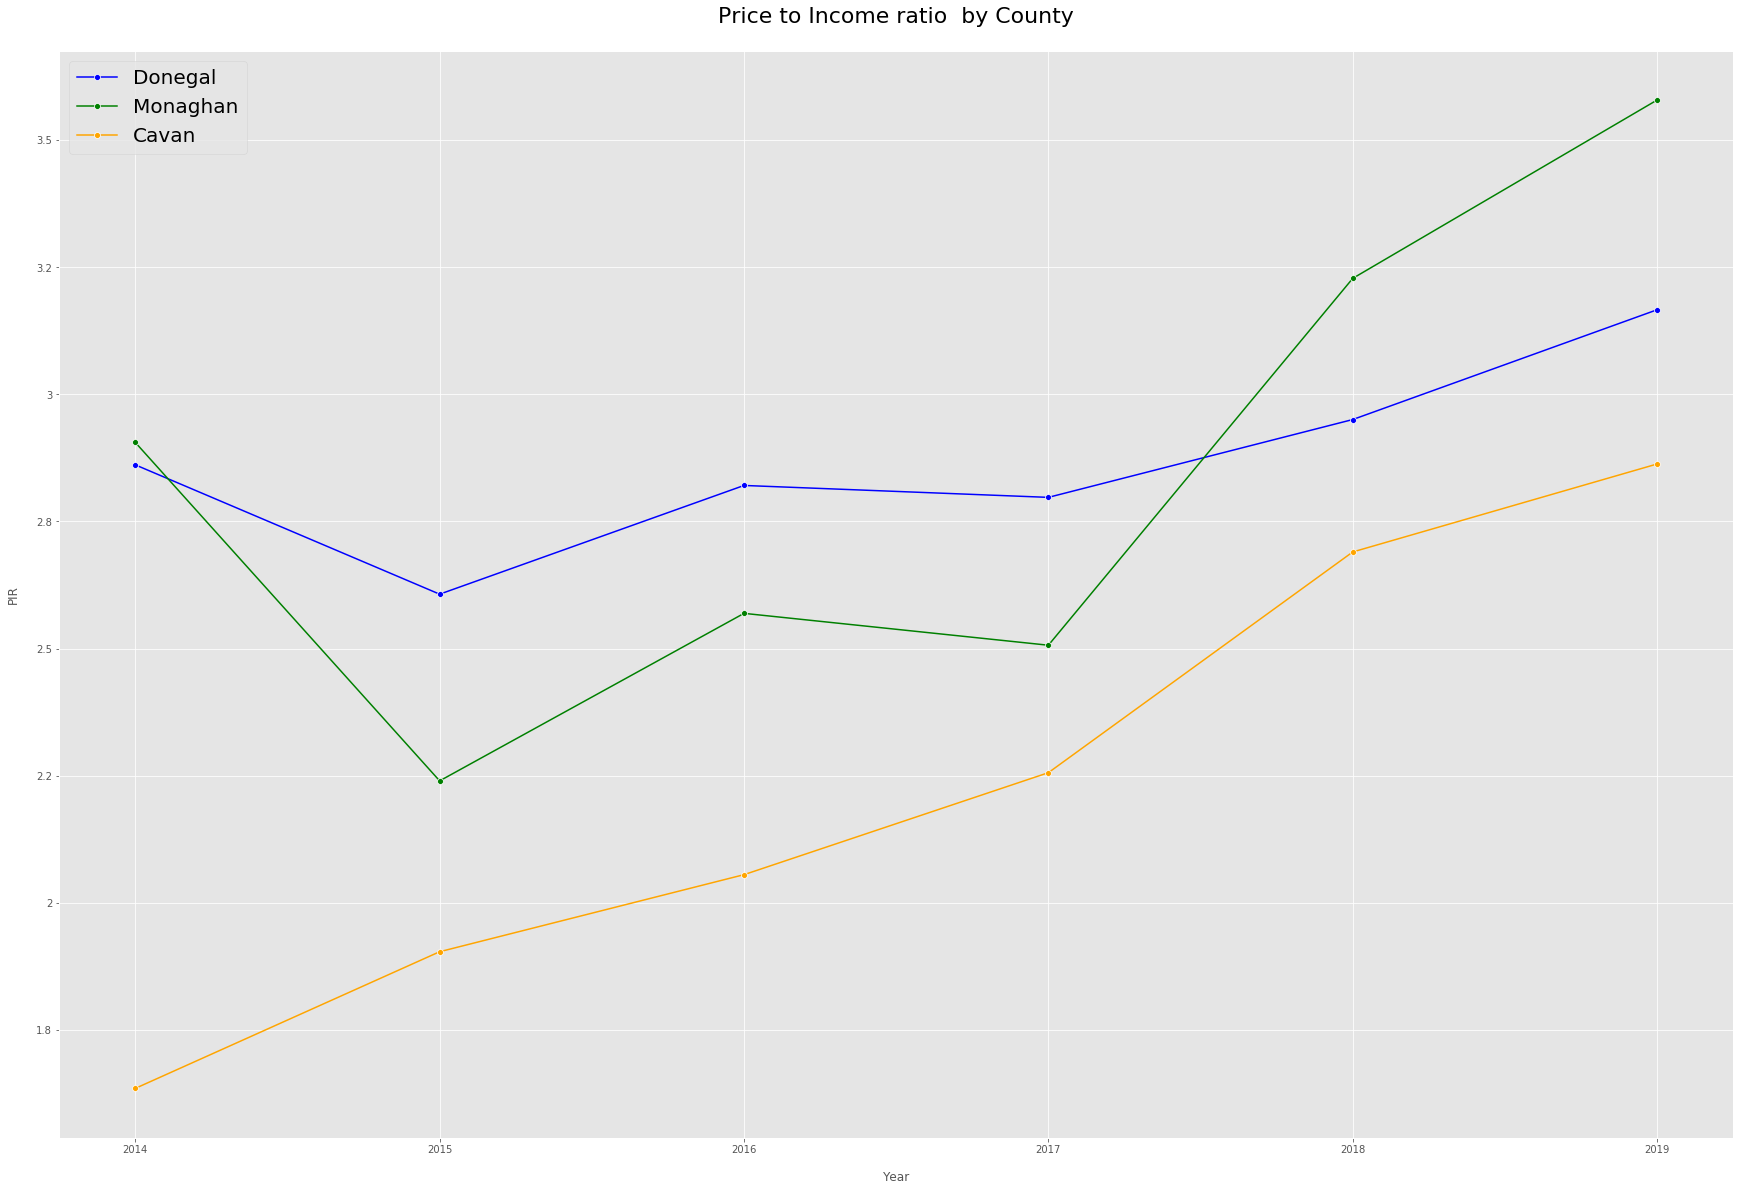

In [33]:
# Price to income ratio (PIR)

fig_dims = (30, 20)
fig, (ax1) = plt.subplots(figsize=fig_dims)

# prepare mask to filter only county level and 12th month of every year
donegal = (market_report_df['p50_12mo_sales'].notnull()) & (market_report_df['County']=='Donegal')
monaghan = (market_report_df['p50_12mo_sales'].notnull()) & (market_report_df['County']=='Monaghan')
cavan = (market_report_df['p50_12mo_sales'].notnull()) & (market_report_df['County']=='Cavan')
x = market_report_df[cavan].Month_end_day.dt.year


ax1 = sns.lineplot(x=x, 
                  y=market_report_df[donegal]['p50_12mo_sales']/d_income_list, 
                  ax=ax1,
                  data = market_report_df[donegal],
                   markers=True, dashes=False,
                   marker="o",
                 c="blue", 
                  label = 'Donegal')


ax1 = sns.lineplot(x=x, 
                  y=market_report_df[monaghan]['p50_12mo_sales']/m_income_list, 
                  ax=ax1,
                  data = market_report_df[monaghan],
                    marker="o",
                 c="green", 
                  label = 'Monaghan')


ax1 = sns.lineplot(x=x, 
                  y=market_report_df[cavan]['p50_12mo_sales']/m_income_list, 
                  ax=ax1,
                  data = market_report_df[cavan],
                   marker="o",
                 c="orange", 
                  label = 'Cavan')


ax1.set_xlabel("Year", labelpad=16)
ax1.set_ylabel("PIR", labelpad=16)
ax1.set_title("Price to Income ratio  by County", y=1.02, fontsize=22)
ax1.yaxis.set_major_formatter(tick.FuncFormatter(tick_value_formatter))
ax1.legend(loc=2, prop={'size': 20})

/Users/mmiraula/pyenv3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


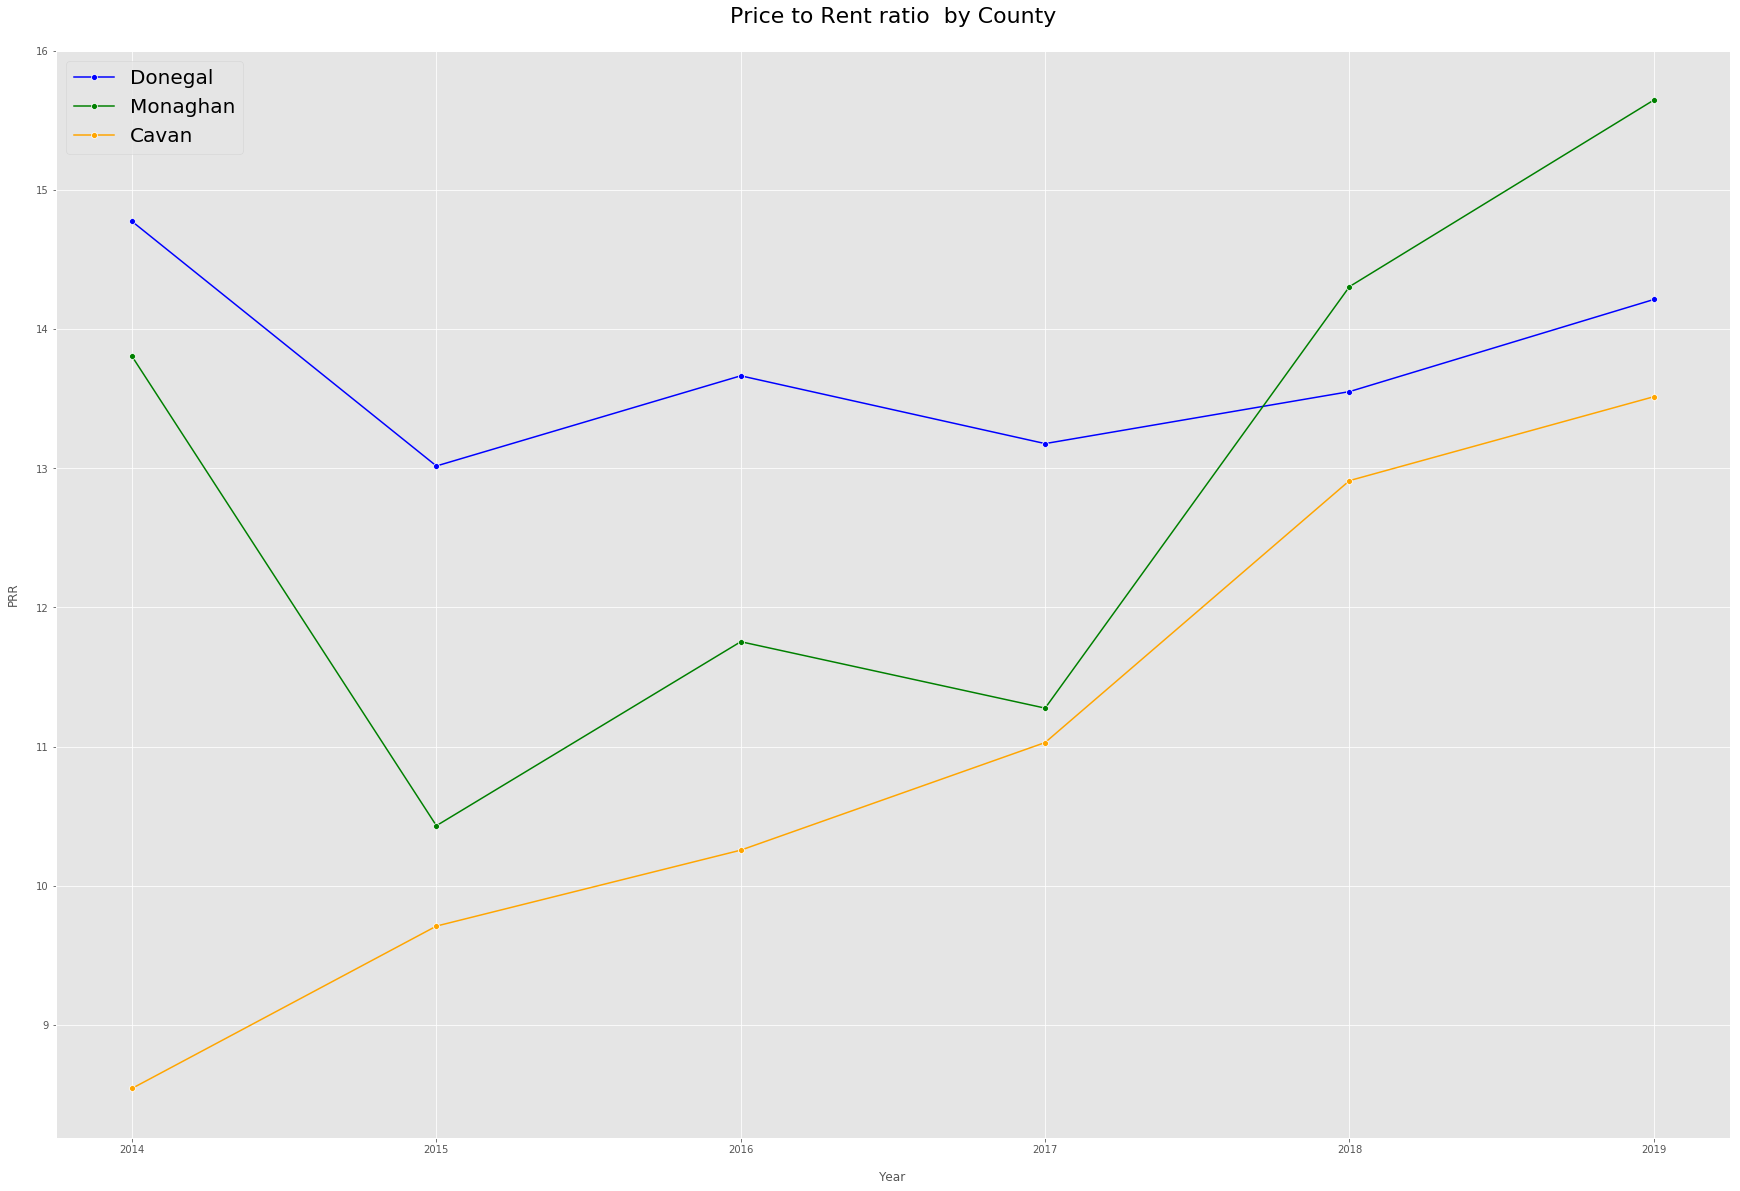

In [34]:
# Price to income ratio (PIR)

fig_dims = (30, 20)
fig, (ax1) = plt.subplots(figsize=fig_dims)

# prepare mask to filter only county level and 12th month of every year
donegal = (market_report_df['p50_12mo_sales'].notnull()) & (market_report_df['County']=='Donegal')
monaghan = (market_report_df['p50_12mo_sales'].notnull()) & (market_report_df['County']=='Monaghan')
cavan = (market_report_df['p50_12mo_sales'].notnull()) & (market_report_df['County']=='Cavan')
x = market_report_df[cavan].Month_end_day.dt.year


ax1 = sns.lineplot(x=x, 
                  y=market_report_df[donegal]['p50_12mo_sales']/d_rent_list, 
                  ax=ax1,
                  data = market_report_df[donegal],
                   markers=True, dashes=False,
                   marker="o",
                 c="blue", 
                  label = 'Donegal')


ax1 = sns.lineplot(x=x, 
                  y=market_report_df[monaghan]['p50_12mo_sales']/m_rent_list, 
                  ax=ax1,
                  data = market_report_df[monaghan],
                    marker="o",
                 c="green", 
                  label = 'Monaghan')


ax1 = sns.lineplot(x=x, 
                  y=market_report_df[cavan]['p50_12mo_sales']/c_rent_list, 
                  ax=ax1,
                  data = market_report_df[cavan],
                   marker="o",
                 c="orange", 
                  label = 'Cavan')


ax1.set_xlabel("Year", labelpad=16)
ax1.set_ylabel("PRR", labelpad=16)
ax1.set_title("Price to Rent ratio  by County", y=1.02, fontsize=22)
ax1.yaxis.set_major_formatter(tick.FuncFormatter(tick_value_formatter))
ax1.legend(loc=2, prop={'size': 20})




The two indicators put in perspective the trends of the housing market with the actual population. In particular, the PIR represent the health of the population that could potentially affor a house, compared with the prices in the county. The PPR represent the potential profit of a long-term investment for a monthly income derived by renting. 

The recommendation here would be to target the market that possess the higher ratios both in terms of PIR and PRR, as they would represent an healthy and lucrative investment. Monaghan present the best compromise, as it shows an constant increase in these ratios. 


## Plotting the changes for Median Prices 

Lastly, we want to evaluate the median price changes over the three months period to understand if there is a seasonal opportunity where the investment makes more sense, for example, because the market undergoes a seasonal shrink. 

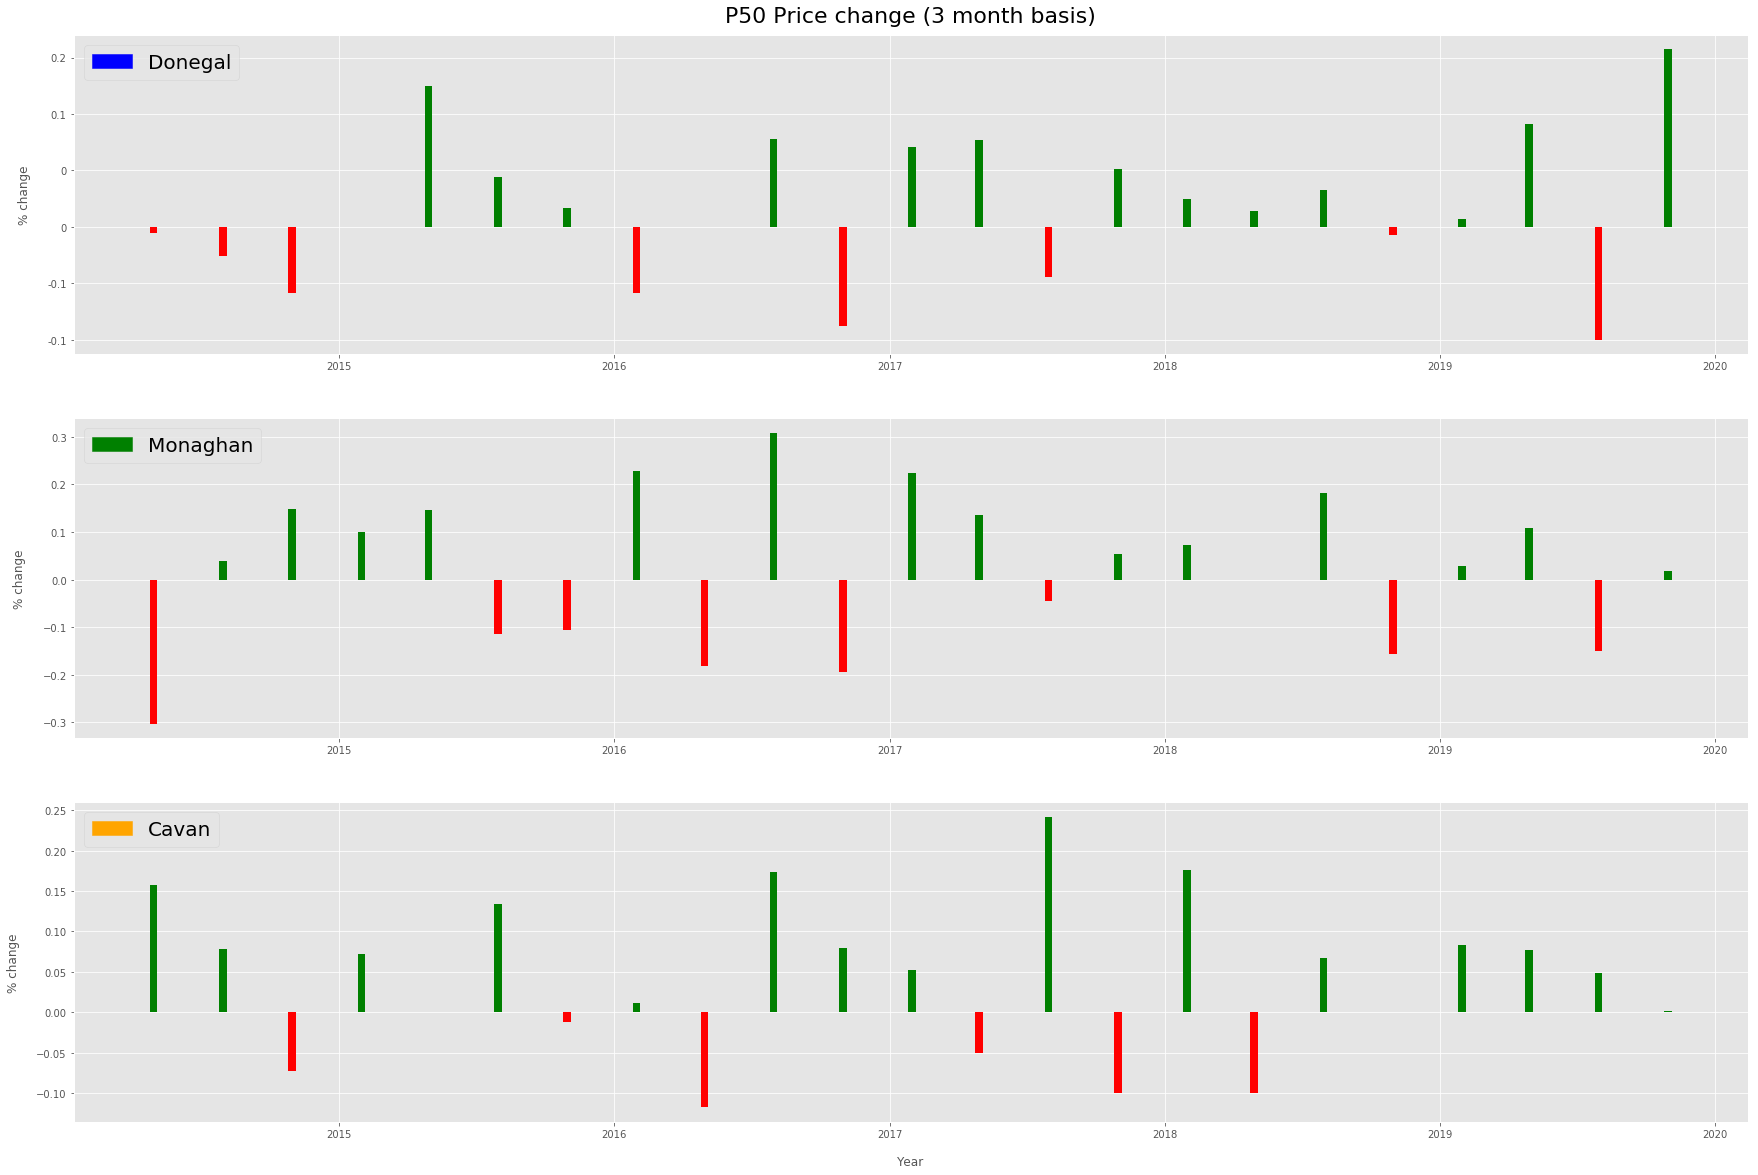

In [35]:
fig_dims = (30, 20)
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=fig_dims)

# here we select the county 
donegal = (market_report_df['p50_3mo_sales_chng'].notnull()) & (market_report_df['County'] == 'Donegal')
monaghan = (market_report_df['p50_3mo_sales_chng'].notnull()) & (market_report_df['County'] == 'Monaghan')
cavan = (market_report_df['p50_3mo_sales_chng'].notnull()) & (market_report_df['County'] == 'Cavan')

market_report_df['Positive'] = (market_report_df['p50_3mo_sales_chng'].notnull()) & (market_report_df['p50_3mo_sales_chng']>0)

ax1.bar(x =market_report_df[donegal]['Month_end_day'],
            height =market_report_df[donegal]['p50_3mo_sales_chng'],
            color=market_report_df[donegal].Positive.map({True: 'g', False: 'r'}), 
           width = 10, label= "Donegal")

ax2.bar(x =market_report_df[monaghan]['Month_end_day'],
            height =market_report_df[monaghan]['p50_3mo_sales_chng'],
            color=market_report_df[monaghan].Positive.map({True: 'g', False: 'r'}), 
           width = 10, label= "Monaghan")

ax3.bar(x =market_report_df[cavan]['Month_end_day'],
            height =market_report_df[cavan]['p50_3mo_sales_chng'],
            color=market_report_df[cavan].Positive.map({True: 'g', False: 'r'}), 
           width = 10, label= "Cavan")

ax3.set_xlabel("Year", labelpad=16)
ax1.set_ylabel("% change", labelpad=16)
ax2.set_ylabel("% change", labelpad=16)
ax3.set_ylabel("% change", labelpad=16)
ax1.set_title("P50 Price change (3 month basis)", y=1.02, fontsize=22)
ax1.yaxis.set_major_formatter(tick.FuncFormatter(tick_value_formatter))
ax1.legend(loc=2, prop={'size': 20})
ax2.legend(loc=2, prop={'size': 20})
ax3.legend(loc=2, prop={'size': 20})
leg1 = ax1.get_legend()
leg1.legendHandles[0].set_color('Blue')
leg2 = ax2.get_legend()
leg2.legendHandles[0].set_color('Green')
leg3 = ax3.get_legend()
leg3.legendHandles[0].set_color('Orange')



At first glance, it looks like Monaghan has a price shirnk in the trimester before the change of the year. This could be a potential target to exploit price changes in the market for a favourable investment. 